In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from log_analyzer import LogAnalyzer

## 0. Summary Stats

In [ ]:
analyzer = LogAnalyzer()
analyzer.parse_logs()

# Display simulation metadata
duration = analyzer.get_simulation_duration()
print(f"Simulation duration: {duration:.2f} seconds")
print(f"Machine clock rates:")
for machine_id, rate in analyzer.machine_rates.items():
    print(f"  Machine {machine_id}: {rate} ticks/sec")


# Display summary statistics
print("Summary Statistics:")
summary_df = analyzer.analyze_data()
display(summary_df)



Parsing log files from logs...
  Parsed 191 events for Machine 1 (Rate: 2 ticks/sec)
  Parsed 255 events for Machine 2 (Rate: 3 ticks/sec)
  Parsed 355 events for Machine 3 (Rate: 5 ticks/sec)
Simulation duration: 60.61 seconds
Machine clock rates:
  Machine 1: 2 ticks/sec
  Machine 2: 3 ticks/sec
  Machine 3: 5 ticks/sec
Summary Statistics:


,events_count,avg_queue_length,max_queue_length,avg_clock_jump,max_clock_jump,internal_events,send_events,receive_events
1,191.0,0.560209,3.0,1.832461,12.0,40.0,29.0,61.0
2,255.0,0.325490,2.0,1.396078,11.0,84.0,41.0,65.0
3,355.0,0.109859,2.0,1.002817,2.0,189.0,94.0,36.0


## 1. Logical Clock Progression

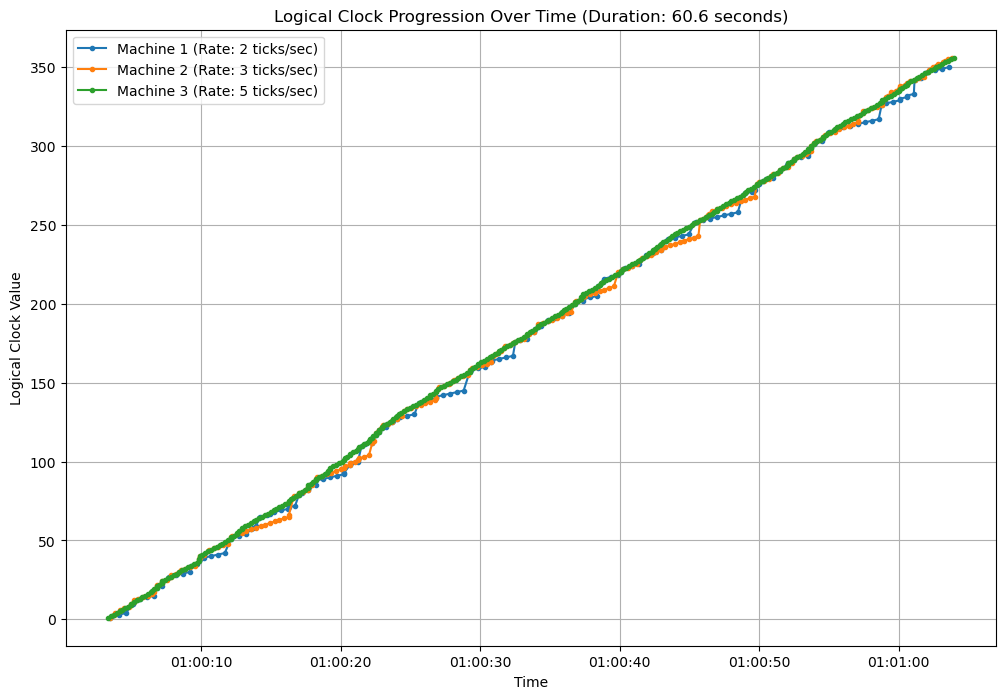

In [ ]:
def plot_clock_progression(analyzer):
    """Plot logical clock progression over time for all machines."""
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Get simulation duration for plot title
    duration = analyzer.get_simulation_duration()

    # Create a plot
    plt.figure(figsize=(12, 8))

    # Plot logical clock values over time for each machine
    for machine_id, df in analyzer.log_data.items():
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        plt.plot(
            df["timestamp"],
            df["logical_clock"],
            label=f"Machine {machine_id} (Rate: {clock_rate} ticks/sec)",
            marker="o",
            markersize=3,
            linestyle="-",
        )

    plt.title(
        f"Logical Clock Progression Over Time (Duration: {duration:.1f} seconds)"
    )
    plt.xlabel("Time")
    plt.ylabel("Logical Clock Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_clock_progression(analyzer)



### TODO: Observations on logical clock progression




## 2. Event distribution

the distribution of event types for each machine.

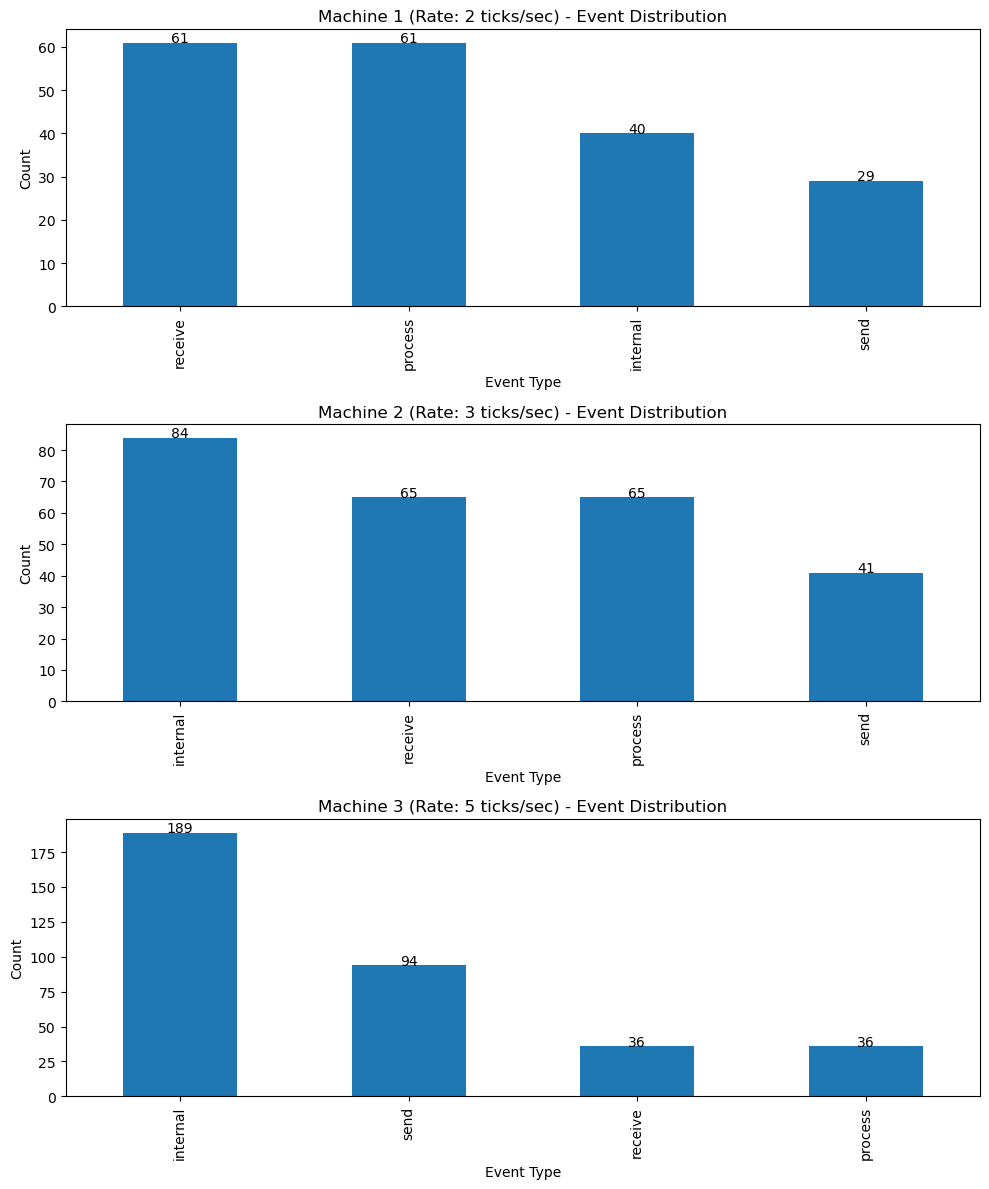

In [ ]:
def plot_event_distribution(analyzer):
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Create a figure with subplots for each machine
    fig, axes = plt.subplots(
        len(analyzer.log_data), 1, figsize=(10, 4 * len(analyzer.log_data))
    )

    # If there's only one machine, wrap the axis in a list for consistent indexing
    if len(analyzer.log_data) == 1:
        axes = [axes]

    for i, (machine_id, df) in enumerate(sorted(analyzer.log_data.items())):
        # Count events by type
        event_counts = df["event_type"].value_counts()

        # Create a bar chart
        event_counts.plot(kind="bar", ax=axes[i])
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        axes[i].set_title(
            f"Machine {machine_id} (Rate: {clock_rate} ticks/sec) - Event Distribution"
        )
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Event Type")

        # Add count labels on bars
        for j, count in enumerate(event_counts):
            axes[i].text(j, count + 0.1, str(count), ha="center")

    plt.tight_layout()
    plt.show()

plot_event_distribution(analyzer)




### TODO 8: Observations on event distribution


## 3. Queue Lengths

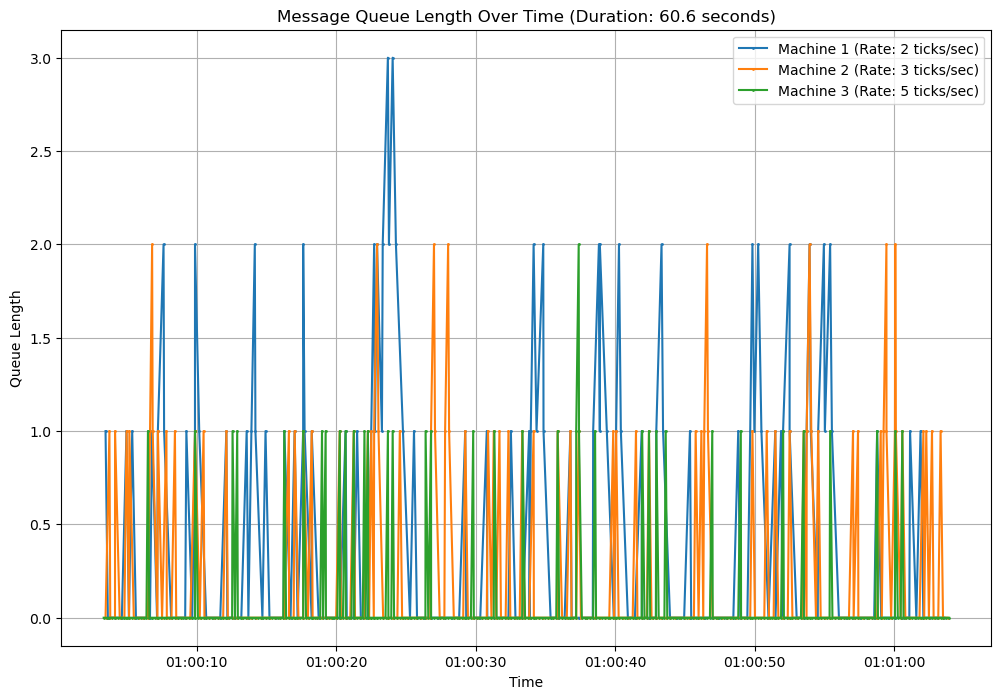

In [5]:
def plot_queue_lengths(analyzer):
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Get simulation duration for plot title
    duration = analyzer.get_simulation_duration()

    # Create a plot
    plt.figure(figsize=(12, 8))

    # Plot queue lengths over time for each machine
    for machine_id, df in analyzer.log_data.items():
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        plt.plot(
            df["timestamp"],
            df["queue_length"],
            label=f"Machine {machine_id} (Rate: {clock_rate} ticks/sec)",
            marker=".",
            markersize=2,
            linestyle="-",
        )

    plt.title(f"Message Queue Length Over Time (Duration: {duration:.1f} seconds)")
    plt.xlabel("Time")
    plt.ylabel("Queue Length")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_queue_lengths(analyzer)




### TODO: Observations on queue lengths


## 4: Clock Jumps

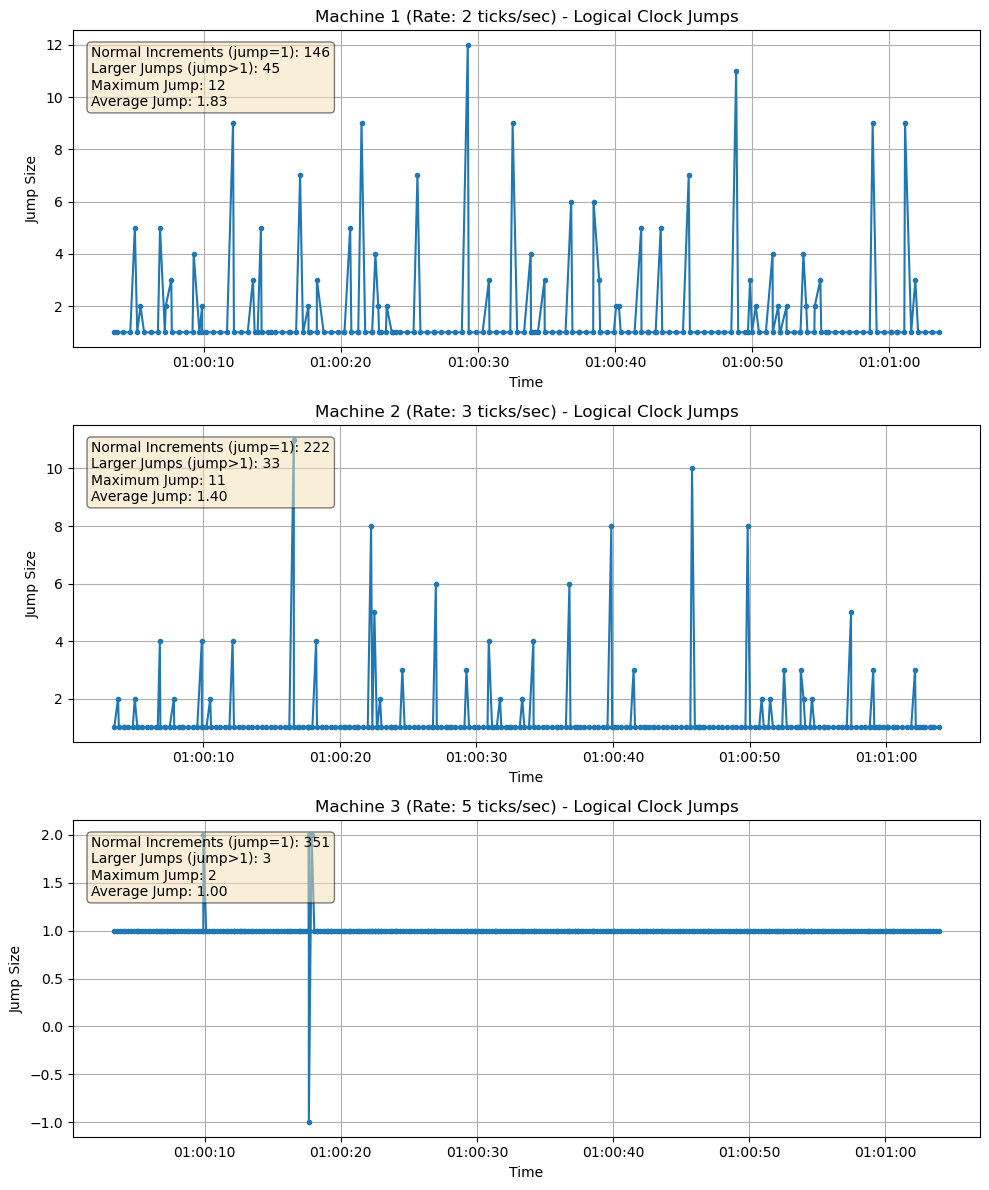

In [6]:
def plot_clock_jumps(analyzer):
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Create a figure with subplots for each machine
    fig, axes = plt.subplots(
        len(analyzer.log_data), 1, figsize=(10, 4 * len(analyzer.log_data))
    )

    if len(analyzer.log_data) == 1:
        axes = [axes]

    for i, (machine_id, df) in enumerate(sorted(analyzer.log_data.items())):
        # Plot clock jumps over time
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        axes[i].plot(df["timestamp"], df["clock_jump"], marker=".", linestyle="-")
        axes[i].set_title(
            f"Machine {machine_id} (Rate: {clock_rate} ticks/sec) - Logical Clock Jumps"
        )
        axes[i].set_ylabel("Jump Size")
        axes[i].set_xlabel("Time")
        axes[i].grid(True)

        # Add stats as text
        jumps_excluding_ones = df[df["clock_jump"] > 1]["clock_jump"]
        stats_text = (
            f"Normal Increments (jump=1): {len(df[df['clock_jump'] == 1])}\n"
            f"Larger Jumps (jump>1): {len(jumps_excluding_ones)}\n"
            f"Maximum Jump: {df['clock_jump'].max():.0f}\n"
            f"Average Jump: {df['clock_jump'].mean():.2f}"
        )
        axes[i].text(
            0.02,
            0.95,
            stats_text,
            transform=axes[i].transAxes,
            verticalalignment="top",
            bbox={"boxstyle": "round", "facecolor": "wheat", "alpha": 0.5},
        )

    plt.tight_layout()
    plt.show()

plot_clock_jumps(analyzer)



### TODO:  Observations on clock jumps


## 5. Maximum Drift

Plot the maximum drift between logical clocks

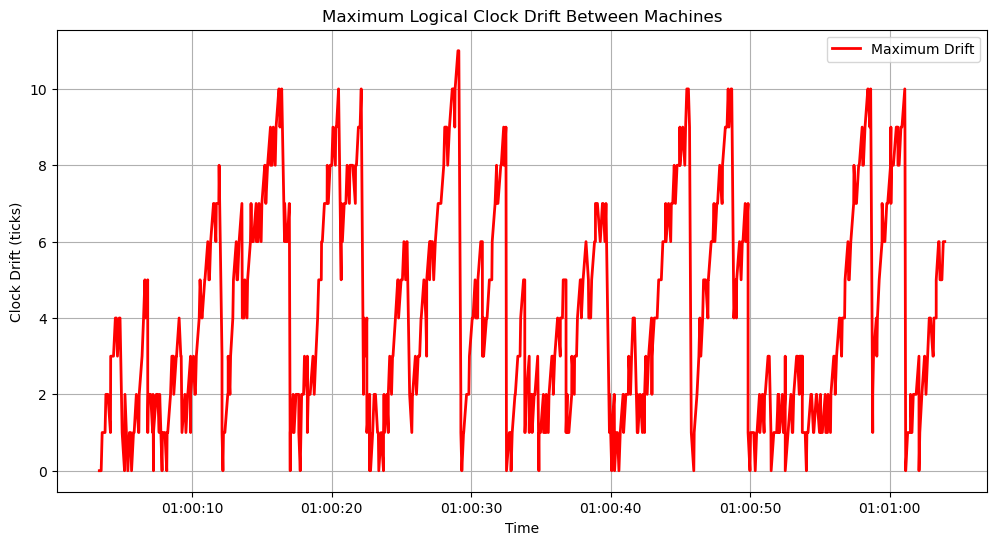

Drift Statistics:
  Mean Drift: 4.03 ticks
  Maximum Drift: 11.00 ticks
  Final Drift: 6.00 ticks


In [7]:
def plot_max_drift(analyzer):
    if not analyzer.log_data or len(analyzer.log_data) < 2:
        return "At least two machines are needed for drift analysis."

    # Sample timestamps at regular intervals
    timestamps = []
    for machine_id, df in analyzer.log_data.items():
        timestamps.extend(df["timestamp"].tolist())

    timestamps = sorted(list(set(timestamps)))

    # Calculate max and min clock values at each timestamp
    drift_data = []
    for ts in timestamps:
        max_clock = 0
        min_clock = float("inf")
        clock_values = {}

        for machine_id, df in analyzer.log_data.items():
            # Find the closest timestamp before or equal to ts
            earlier_events = df[df["timestamp"] <= ts]
            if not earlier_events.empty:
                clock_value = earlier_events.iloc[-1]["logical_clock"]
                max_clock = max(max_clock, clock_value)
                min_clock = min(min_clock, clock_value)
                clock_values[machine_id] = clock_value

        if min_clock != float("inf"):
            drift_data.append(
                {
                    "timestamp": ts,
                    "max_drift": max_clock - min_clock,
                    "clock_values": clock_values,
                }
            )

    # Plot the drift over time
    plt.figure(figsize=(12, 6))

    # Convert to DataFrame for easier plotting
    drift_df = pd.DataFrame(drift_data)

    # Plot max drift
    plt.plot(
        drift_df["timestamp"],
        drift_df["max_drift"],
        label="Maximum Drift",
        color="red",
        linewidth=2,
    )

    plt.title("Maximum Logical Clock Drift Between Machines")
    plt.xlabel("Time")
    plt.ylabel("Clock Drift (ticks)")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Return some statistics about the drift
    return {
        "mean_drift": drift_df["max_drift"].mean(),
        "max_drift": drift_df["max_drift"].max(),
        "final_drift": drift_df["max_drift"].iloc[-1] if not drift_df.empty else None
    }


drift_stats = plot_max_drift(analyzer)
print("Drift Statistics:")
print(f"  Mean Drift: {drift_stats.get('mean_drift', 'N/A'):.2f} ticks")
print(f"  Maximum Drift: {drift_stats.get('max_drift', 'N/A'):.2f} ticks")
print(f"  Final Drift: {drift_stats.get('final_drift', 'N/A'):.2f} ticks")


### TODO: Observations on clock drift


# TODO: Final summary and conclusions


Summary and Conclusions:

1. Overall System Behavior:
   - [Summary of the distributed system's overall behavior]
   - [Observations about how well the logical clocks maintained causality]

2. Impact of Different Clock Rates:
   - [Summary of how different clock rates affected system behavior]
   - [Observations about message queuing and processing]

3. Lamport's Logical Clock Implementation Effectiveness:
   - [Assessment of how well the logical clock implementation worked]
   - [Observations about drift and synchronization]

4. Key Insights:
   - [List the most important insights gained from this analysis]
   - [Any recommendations for improving the distributed system]